In [60]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [61]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


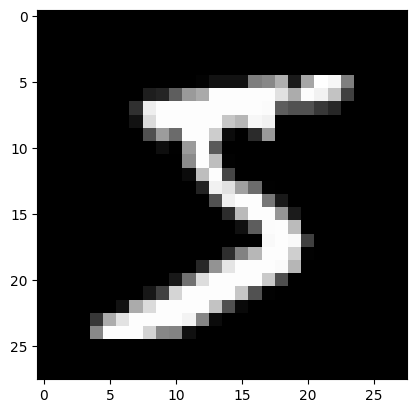

In [62]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

将数据转换成tensor进行下一部训练

In [63]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


torch.nn.functional

In [64]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb.mm(weights) + bias

In [65]:
batch_size = 64
x_batch = x_train[0 : batch_size]
y_batch = y_train[0 : batch_size]
weights = torch.randn([784, 10], dtype=torch.float, requires_grad=True)
bias = torch.zeros(10, requires_grad=True)

print(loss_func(model(x_batch), y_batch))

tensor(13.2525, grad_fn=<NllLossBackward0>)


### 创建一个model来更简化代码

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [66]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [67]:
net = Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


打印定义好的模型的权重和偏置

In [68]:
for name, parameter in net.named_parameters():
    print(name, parameter, parameter.size())

hidden1.weight Parameter containing:
tensor([[-9.7687e-03,  3.3490e-02,  3.1418e-02,  ...,  7.8820e-04,
         -3.3797e-02,  2.7085e-02],
        [ 2.4814e-02, -2.8388e-03, -3.3557e-02,  ..., -1.2632e-02,
          1.5439e-02,  5.1867e-05],
        [-3.1017e-02,  1.5471e-02,  9.2429e-03,  ...,  7.8650e-03,
          1.9177e-02, -3.4153e-02],
        ...,
        [-1.1203e-02, -1.9561e-02, -1.8574e-02,  ..., -2.9111e-02,
          2.5718e-04,  1.9563e-02],
        [ 9.0497e-03, -5.4587e-03,  1.1664e-02,  ...,  7.6353e-04,
         -1.5564e-02, -3.2511e-02],
        [ 1.6134e-02, -6.6140e-03, -2.3366e-02,  ..., -3.1180e-02,
         -2.2621e-02, -1.2628e-02]], requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([-0.0151, -0.0043,  0.0081, -0.0332,  0.0190, -0.0005, -0.0208,  0.0327,
         0.0331, -0.0115, -0.0305,  0.0349,  0.0121, -0.0027, -0.0204,  0.0035,
        -0.0102,  0.0062, -0.0140, -0.0048,  0.0111, -0.0289,  0.0297, -0.0084,
        -0.01

### 使用TensorDataset和DataLoader来简化

In [69]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(x_valid, y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size * 2)

In [70]:
def get_data(train_dataset, valid_dataset, batch_size):
    return(
        DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
        DataLoader(valid_dataset, batch_size=batch_size * 2)
    )

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [71]:
import numpy as np

def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))

In [72]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [73]:
def loss_batch(model, loss_func, x_batch, y_batch, opt=None):
    loss = loss_func(model(x_batch), y_batch)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x_batch)

三行代码训练

In [74]:
train_dataloader, valid_dataloader = get_data(train_dataset, valid_dataset, batch_size)
model, opt = get_model()
fit(25, model, loss_func, opt, train_dataloader, valid_dataloader)

当前step:0 验证集损失：2.273840909957886
当前step:1 验证集损失：2.2378461971282957
当前step:2 验证集损失：2.180317672729492
当前step:3 验证集损失：2.0869997482299807
当前step:4 验证集损失：1.9418668437957765
当前step:5 验证集损失：1.7389909128189087
当前step:6 验证集损失：1.4970291734695436
当前step:7 验证集损失：1.2587316648483275
当前step:8 验证集损失：1.0615837144851685
当前step:9 验证集损失：0.913150549697876
当前step:10 验证集损失：0.8025664088249207
当前step:11 验证集损失：0.7183412997245788
当前step:12 验证集损失：0.653994692993164
当前step:13 验证集损失：0.602191332435608
当前step:14 验证集损失：0.5609250089168548
当前step:15 验证集损失：0.5271173244476318
当前step:16 验证集损失：0.4992374366283417
当前step:17 验证集损失：0.475953571844101
当前step:18 验证集损失：0.45569732608795166
当前step:19 验证集损失：0.43864184346199037
当前step:20 验证集损失：0.423611288356781
当前step:21 验证集损失：0.4108819365024567
当前step:22 验证集损失：0.3996848051786423
当前step:23 验证集损失：0.38955236513614655
当前step:24 验证集损失：0.3811506537437439
